<a href="https://colab.research.google.com/github/saugabriele/NetSec_lab/blob/main/NetSec_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NetSec Project** - Sau Gabriele 70-90-00474

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split

# Mounting Google Drive to access files stored there
drive.mount("/content/drive")

# Reading the CSV file into a pandas DataFrame and sorting the columns alphabetically
file_path = "/content/drive/My Drive/Train_Test_Network.csv"
traffic_df = pd.read_csv(file_path)
traffic_df = traffic_df.sort_index(axis=1)

# Displaying the count of each unique value in the 'type' column
print(traffic_df['type'].value_counts().sort_index())

# Selecting a subset of the DataFrame for analysis
analysis_df = traffic_df[['conn_state', 'proto', 'type', 'dst_pkts',
                          'src_pkts', 'dst_bytes', 'src_bytes']]

Mounted at /content/drive
type
backdoor       20000
ddos           20000
dos            20000
injection      20000
mitm            1043
normal        300000
password       20000
ransomware     20000
scanning       20000
xss            20000
Name: count, dtype: int64


In [4]:
# Mapping original categories to new categories
category_mapping = {
    'backdoor': 'Other',
    'ddos': 'DoS or DDoS',
    'dos': 'DoS or DDoS',
    'injection': 'Other',
    'mitm': 'Other',
    'normal': 'Other',
    'password': 'Other',
    'ransomware': 'Other',
    'scanning': 'Other',
    'xss': 'Other'
}

# Replacing the 'type' column values based on the category mapping
analysis_df.loc[:, 'type'] = analysis_df['type'].replace(category_mapping)

# Group the DataFrame by the 'type' column and then count the occurrences of each protocol
type_proto_counts = analysis_df.groupby('type')['proto'].value_counts().unstack(fill_value=0)
print(type_proto_counts)

# Shuffling the DataFrame to ensure a random distribution of rows
clean_df = analysis_df.sample(frac=1).reset_index(drop=True)

# Defining the split ratio for the dataset
train_size = 0.8

# Splitting the DataFrame into training and testing sets based on the defined ratio
train_df, test_df = train_test_split(clean_df, train_size=train_size, random_state=42)

proto        icmp     tcp     udp
type                             
DoS or DDoS     0   33250    6750
Other        5880  248826  166337


#TCP Flooding

In [5]:
import matplotlib.pyplot as plt

def plot_conn_state_percentages(subset_numbers, percent_sus, percent_not_sus, title):
    """
      Goal: Printing the percentage of suspicious and non-suspicious
            connection state inside each flow of packets.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(subset_numbers, percent_not_sus, label='Not Suspicious', marker='o')
    plt.plot(subset_numbers, percent_sus, label='Suspicious', marker='o')

    plt.xlabel('Subset Number')
    plt.title(title)
    plt.legend()
    plt.ylim(0, max(max(percent_not_sus), max(percent_sus))+2)
    plt.grid(True)
    plt.show()

In [6]:
# Mapping connection states to 'Suspicious' or 'Not Suspicious' categories
DoS_conn_state_mapping = {
    'S0': 'Suspicious',
    'SF': 'Not Suspicious',
    'OTH': 'Not Suspicious',
    'RSTR': 'Suspicious',
    'SH': 'Suspicious',
    'SHR': 'Suspicious',
    'REJ': 'Suspicious',
    'S3': 'Not Suspicious',
    'S1': 'Not Suspicious',
    'RSTO': 'Suspicious',
    'RSTRH': 'Not Suspicious',
    'S2': 'Not Suspicious',
    'RSTOS0': 'Suspicious'
}

# Replacing the 'conn_state' values for TCP packets using the DoS_conn_state_mapping
tcp_mask = train_df['proto'] == 'tcp'
train_df.loc[tcp_mask, 'conn_state'] = train_df.loc[tcp_mask, 'conn_state'].replace(DoS_conn_state_mapping)

# Creating subsets of the training DataFrame, each containing 'subset_size' rows
subset_size = 1000
subsets = [train_df.iloc[i:i + subset_size] for i in range(0, len(train_df), subset_size)]

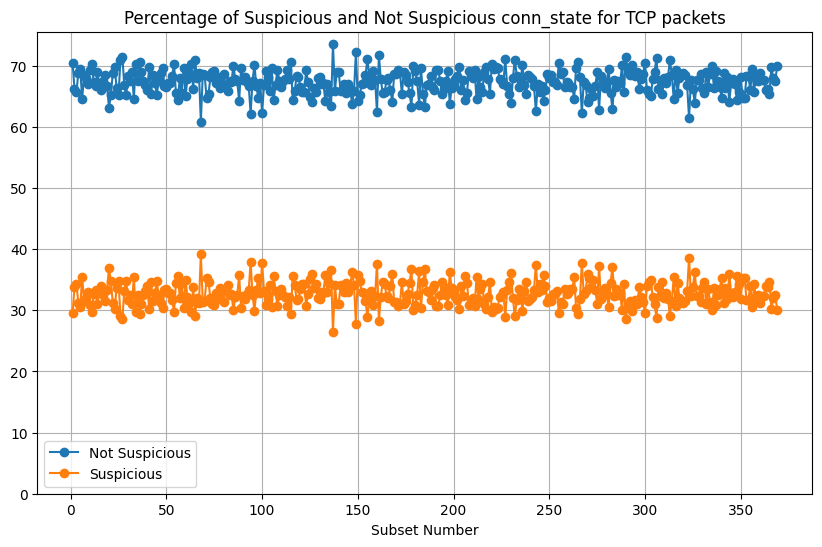

Threshold: 50.0000


In [7]:
# Initialize lists to store the percentage results of connection states
percent_conn_state_not_sus = []
percent_conn_state_sus = []

# Calculate the percentage of each suspicious and not suspicious connection states in each subset
subset_numbers = []
for i, subset in enumerate(subsets, start=1):
    total_conn_state_not_sus = subset[subset['conn_state'] == 'Not Suspicious']['conn_state'].value_counts(normalize=False)
    total_conn_state_sus = subset[subset['conn_state'] == 'Suspicious']['conn_state'].value_counts(normalize=False)
    total_conn_state_not_sus = total_conn_state_not_sus.get('Not Suspicious', 0)
    total_conn_state_sus = total_conn_state_sus.get('Suspicious', 0)

    total_number_of_TCP = total_conn_state_not_sus + total_conn_state_sus

    # Append the subset number to the list
    subset_numbers.append(i)
    # Calculate and append the percentages to the lists, avoiding division by zero
    if total_number_of_TCP !=0:
      percent_conn_state_not_sus.append(total_conn_state_not_sus * 100 / total_number_of_TCP)
      percent_conn_state_sus.append(total_conn_state_sus * 100 / total_number_of_TCP)
    else:
      percent_conn_state_not_sus.append(100)
      percent_conn_state_sus.append(0)

# Plot the percentages of suspicious and not suspicious connection states
title_plot = "Percentage of Suspicious and Not Suspicious conn_state for TCP packets"
plot_conn_state_percentages(subset_numbers, percent_conn_state_sus,
                            percent_conn_state_not_sus, title_plot)

# Calculate the threshold as the average of the two percentage averages
threshold_tcp = (np.average(percent_conn_state_not_sus) + np.average(percent_conn_state_sus))/2
print(f'Threshold: {threshold_tcp:.4f}')

#UDP flooding

In [8]:
def plot_udp_features(subset_numbers, features, titles):
    """
      Goal: Printing the mean values related to each feature of the packets
            contained in a subset for both DoS_or_DDoS and Other classes.
    """
    fig, axs = plt.subplots(4, 1, figsize=(10, 30))
    for i in range(4):
      axs[i].plot(subset_numbers, features[(i*2)+1], label='Others', marker='o')
      axs[i].plot(subset_numbers, features[(i*2)], label='Dos or DDoS', marker='o')

      axs[i].set_xlabel('Subset Number')
      axs[i].set_title(titles[i])
      axs[i].legend()
      axs[i].set_ylim(0, max(max(features[(i*2)]), max(features[(i*2)+1]))+2)
      axs[i].grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
# Initialize lists to store mean values of packets and bytes for DoS and non-DoS
mean_dst_pkts_DoS = []
mean_dst_pkts_not_DoS = []
mean_src_pkts_DoS = []
mean_src_pkts_not_DoS = []
mean_dst_bytes_DoS = []
mean_dst_bytes_not_DoS = []
mean_src_bytes_DoS = []
mean_src_bytes_not_DoS = []

# Create subsets of the training DataFrame, each containing 'subset_size' rows
subset_size = 1000
subset_numbers = []
subsets = [train_df.iloc[i:i + subset_size] for i in range(0, len(train_df), subset_size)]


# Loop through each subset to calculate mean values of packets and bytes
for i, subset in enumerate(subsets, start=1):
    DoS_or_DDoS = subset[(subset['type'] == 'DoS or DDoS') & (subset['proto'] == 'udp')]
    Others = subset[(subset['type'] == 'Other') & (subset['proto'] == 'udp')]

    # Append the subset number to the list
    subset_numbers.append(i)

    # Calculate and append mean values
    mean_dst_pkts_DoS.append(DoS_or_DDoS['dst_pkts'].astype(int).mean())
    mean_dst_pkts_not_DoS.append(Others['dst_pkts'].astype(int).mean())
    mean_src_pkts_DoS.append(DoS_or_DDoS['src_pkts'].astype(int).mean())
    mean_src_pkts_not_DoS.append(Others['src_pkts'].astype(int).mean())
    mean_dst_bytes_DoS.append(DoS_or_DDoS['dst_bytes'].astype(int).mean())
    mean_dst_bytes_not_DoS.append(Others['dst_bytes'].astype(int).mean())
    mean_src_bytes_DoS.append(DoS_or_DDoS['src_bytes'].astype(int).mean())
    mean_src_bytes_not_DoS.append(Others['src_bytes'].astype(int).mean())


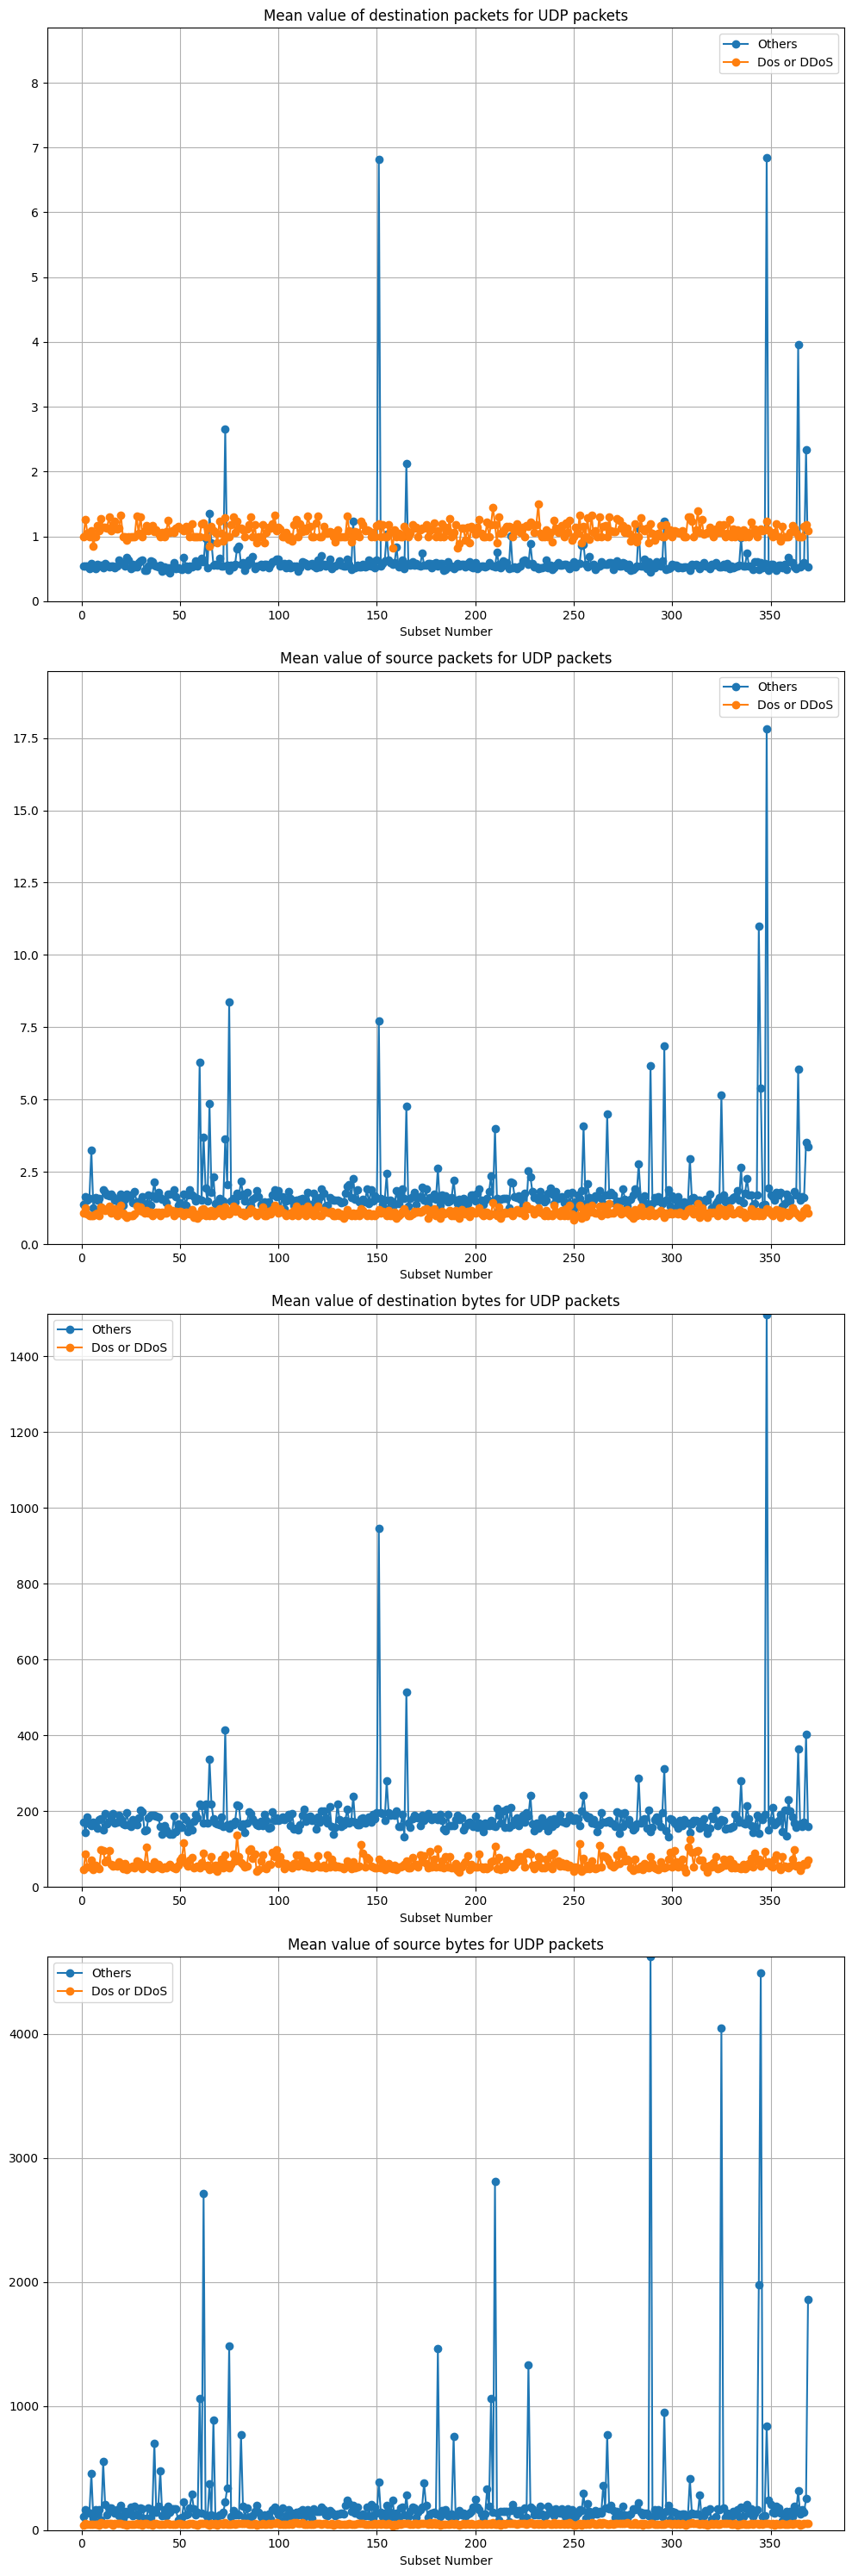

In [10]:
# Titles for the plots
plot_titles = ["Mean value of destination packets for UDP packets",
               "Mean value of source packets for UDP packets",
               "Mean value of destination bytes for UDP packets",
               "Mean value of source bytes for UDP packets"]


# Mean values lists combined for easier plotting
mean_values = [mean_dst_pkts_DoS, mean_dst_pkts_not_DoS,
               mean_src_pkts_DoS, mean_src_pkts_not_DoS,
               mean_dst_bytes_DoS, mean_dst_bytes_not_DoS,
               mean_src_bytes_DoS, mean_src_bytes_not_DoS]

plot_udp_features(subset_numbers, mean_values, plot_titles)

In [11]:
# Calculate the thresholds
threshold_dst_pkts = (np.average(mean_values[0]) + np.average(mean_values[1]))/2
threshold_src_pkts = (np.average(mean_values[2]) + np.average(mean_values[3]))/2
threshold_dst_bytes = (np.average(mean_values[4]) + np.average(mean_values[5]))/2
threshold_src_bytes = (np.average(mean_values[6]) + np.average(mean_values[7]))/2

# Printing the thresholds
print(f'Threshold mean destination packets: {threshold_dst_pkts:.4f}')
print(f'Threshold mean source packets: {threshold_src_pkts:.4f}')
print(f'Threshold mean destination bytes: {threshold_dst_bytes:.4f}')
print(f'Threshold mean source bytes: {threshold_src_bytes:.4f}')

Threshold mean destination packets: 0.8633
Threshold mean source packets: 1.4757
Threshold mean destination bytes: 124.1553
Threshold mean source bytes: 143.9098


In [12]:
# Initialize lists to store percentage results for each feature compared to the thresholds
percent_dst_pkts_higher = []
percent_src_pkts_lower =[]
percent_dst_bytes_lower = []
percent_src_bytes_lower = []

subset_numbers = []

# Loop through each subset to calculate the percentage of packets meeting certain criteria
for i, subset in enumerate(subsets, start=1):
  percent_dst_pkts_higher.append(len(subset[subset['dst_pkts'] > threshold_dst_pkts]) / len(subset))
  percent_src_pkts_lower.append(len(subset[subset['src_pkts'] < threshold_src_pkts]) / len(subset))
  percent_dst_bytes_lower.append(len(subset[subset['dst_bytes'] < threshold_dst_bytes]) / len(subset))
  percent_src_bytes_lower.append(len(subset[subset['src_pkts'] < threshold_src_bytes]) / len(subset))

# Initialize and fill the list to store the calculated threshold percentages for UDP traffic
thresholds_udp = []
thresholds_udp.append(np.mean(percent_dst_pkts_higher))
thresholds_udp.append(np.mean(percent_src_pkts_lower))
thresholds_udp.append(np.mean(percent_dst_bytes_lower))
thresholds_udp.append(np.mean(percent_src_bytes_lower))

print(f'Percentage of packets with higher dst_pkts than threshold mean destination packets: {thresholds_udp[0]:.4f}')
print(f'Percentage of packets with lower src_pkts than threshold mean source packets: {thresholds_udp[1]:.4f}')
print(f'Percentage of packets with lower dst_bytes than threshold mean destination bytes: {thresholds_udp[2]:.4f}')
print(f'Percentage of packets with lower src_bytes than threshold mean source bytes: {thresholds_udp[3]:.4f}')

Percentage of packets with higher dst_pkts than threshold mean destination packets: 0.4942
Percentage of packets with lower src_pkts than threshold mean source packets: 0.7129
Percentage of packets with lower dst_bytes than threshold mean destination bytes: 0.7262
Percentage of packets with lower src_bytes than threshold mean source bytes: 0.9987


In [16]:
actual_label = []

# Prompt the user to choose a dataset for validating NTC
print("What dataset you want to use to validate NTC? [Other, DoS or DDoS]")
ds_choice = input()

# Validate the user choice and create the validation dataset accordingly
if ds_choice == 'Other':
    ds_validation = test_df.loc[test_df['type'] == 'Other']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(0)
elif ds_choice == 'DoS or DDoS':
    ds_validation = test_df.loc[test_df['type'] == 'DoS or DDoS']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(1)
else:
    ds_validation = test_df.loc[test_df['type'] == 'Other']
    for i in range(0, int(len(ds_validation) / subset_size)):
        actual_label.append(0)
    print("Error")

What dataset you want to use to validate NTC? [Other, DoS or DDoS]
DoS or DDoS


In [17]:
def NTC(dataset, threshold_TCP, thresholds_UDP, subset_size):
    '''
      It analyzes network traffic data to classify each subset of the dataset as
      either a DoS/DDoS attack or other types of traffic. The classification is
      based on the proportion of "Suspicious" TCP connections and certain
      conditions for UDP packet features, compared against predefined thresholds.
    '''

    category_mapping = {
      'S0': 'Suspicious',
      'SF': 'Not Suspicious',
      'OTH': 'Not Suspicious',
      'RSTR': 'Suspicious',
      'SH': 'Suspicious',
      'SHR': 'Suspicious',
      'REJ': 'Suspicious',
      'S3': 'Not Suspicious',
      'S1': 'Not Suspicious',
      'RSTO': 'Suspicious',
      'RSTRH': 'Not Suspicious',
      'S2': 'Not Suspicious',
      'RSTOS0': 'Suspicious'
    }

    # Apply the category mapping to the 'conn_state' column for TCP packets only
    tcp_mask = dataset['proto'] == 'tcp'
    dataset.loc[tcp_mask, 'conn_state'] = dataset.loc[tcp_mask, 'conn_state'].replace(category_mapping)

    # Split the dataset into smaller subsets based on the given subset size
    subsets = [dataset.iloc[i:i + subset_size] for i in range(0, len(dataset), subset_size)]

    predicted_label = []
    classification = 0

    # Loop through each subset and perform the classification
    for i, subset in enumerate(subsets, start=1):
      # Count occurrences of 'Not Suspicious' and 'Suspicious' states in the current subset
      total_conn_state_not_sus = subset[subset['conn_state'] == 'Not Suspicious']['conn_state'].value_counts(normalize=False)
      total_conn_state_sus = subset[subset['conn_state'] == 'Suspicious']['conn_state'].value_counts(normalize=False)
      total_conn_state_not_sus = total_conn_state_not_sus.get('Not Suspicious', 0)
      total_conn_state_sus = total_conn_state_sus.get('Suspicious', 0)

      # Calculate the total number of TCP packets in the current subset
      total_number_of_TCP = total_conn_state_not_sus + total_conn_state_sus
      # Calculate the total number of UDP packets in the dataset
      total_number_of_UDP = len(dataset[dataset['proto'] == 'udp'])

      # Calculate the percentage of UDP packets meeting certain criteria
      percent_dst_pkts_higher = len(dataset[(dataset['proto'] == 'udp') & (dataset['dst_pkts'] > thresholds_UDP[0])]) / total_number_of_UDP
      percent_src_pkts_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['src_pkts'] < thresholds_UDP[1])]) / total_number_of_UDP
      percent_dst_bytes_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['dst_bytes'] < thresholds_UDP[2])]) / total_number_of_UDP
      percent_src_bytes_lower = len(dataset[(dataset['proto'] == 'udp') & (dataset['src_pkts'] < thresholds_UDP[3])]) / total_number_of_UDP

      # Calculate the percentage of suspicious TCP connections
      if total_number_of_TCP != 0:
        percent_conn_state_sus = (total_conn_state_sus * 100 / total_number_of_TCP)
      else:
        percent_conn_state_sus = 0

      # Classify the subset as DoS/DDoS (1) or Other (0) based on threshold conditions
      if (percent_conn_state_sus > threshold_TCP or
          percent_dst_pkts_higher > thresholds_UDP[0] or
          percent_src_pkts_lower > thresholds_UDP[1] or
          percent_dst_bytes_lower > thresholds_UDP[2] or
          percent_src_bytes_lower > thresholds_UDP[3]):
          classification = 1
      else:
          classification = 0

      # Append the classification result to the predicted labels list
      predicted_label.append(classification)

    return predicted_label

In [18]:
# Run the NTC function on the validation dataset to obtain predicted labels for each subset
predicted_labels_single = NTC(ds_validation, threshold_tcp, thresholds_udp, subset_size)

count = 0

# Loop through each subset index to compare predicted labels with actual labels
for i in range(0, int(len(ds_validation) / subset_size)):
    if predicted_labels_single[i] == actual_label[i]:
        count += 1

# Calculate the accuracy as the percentage of correct predictions
accuracy = (count * 100) / int(len(ds_validation) / subset_size)

# Print the accuracy of the classification
print("Accuracy: ", accuracy)

Accuracy:  100.0
